# Import libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Load Dataset

In [3]:
df=pd.read_csv("D:/iti2/NLP/final project/Data Fetching/dialects_data.csv")

In [4]:
data = df.copy()
data = data.drop('id',axis=1)
data.head(15)

,text,dialect
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY
5,@alibobkr63 او حتى من اي دين او طائفة. اسف ممك...,LY
6,@muhamed01111 باهي نستنوه. بلكي مشغول ولا حاجة,LY
7,@muhamed01111 مهما اختلفنا راه نحنا خوت. والله...,LY
8,@muhamed01111 بالنسبة ليا انا والله شبعت هم ون...,LY
9,@Ajo32asLibya @Jed_ly مو نحنا الحياة عندنا مية...,LY


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     147725 non-null  object
 1   dialect  147725 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


# **EDA**

NaN check:
 text       False
dialect    False
dtype: bool

Duplicated rows:
 0         False
1         False
2         False
3         False
4         False
          ...  
147720    False
147721    False
147722    False
147723    False
147724    False
Length: 147725, dtype: bool

Number of duplicated rows: 0

dialect value counts:
 dialect
EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: count, dtype: int64


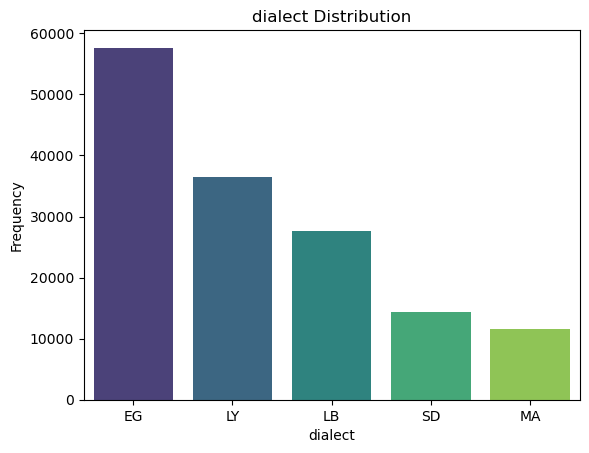


Sample text (index 58407):
 @badawy_afaaf العيال دي لازم تتربى هما واهاليهم اللي معرفوش يربوهم دا اذا كان لهم اهل ..ونرجع تاني بقه نخلي المدرجات فاضية احسن بلا جمهور بلا كلام فاضي ...

Label EG percentage: 39.02%

Label LY percentage: 24.71%

Label LB percentage: 18.69%

Label SD percentage: 9.77%

Label MA percentage: 7.81%


In [6]:
def EDA(data):
    # Check for NaNs
    nan= data.isnull().any()
    print("NaN check:\n", nan)
    
    # Check for duplicates
    duplicated = data.duplicated() 
    print("\nDuplicated rows:\n", duplicated)
    duplicate_count = data.duplicated().sum()
    print("\nNumber of duplicated rows:", duplicate_count)
    
    # Show a representative sample of data texts
    label_counts = data['dialect'].value_counts()
    print("\ndialect value counts:\n", label_counts)
    
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('dialect Distribution')
    plt.xlabel('dialect')
    plt.ylabel('Frequency')
    plt.show()
    
    # Sample a random text
    sample_index = np.random.randint(0, len(data))
    sample_text = data.iloc[sample_index]['text']
    print("\nSample text (index {}):\n".format(sample_index), sample_text)
    
    # Check dataset balancing
    total_count = df.shape[0]
    for label in label_counts.index:
        label_percentage = (label_counts[label] / total_count) * 100
        print("\nLabel {} percentage: {:.2f}%".format(label, label_percentage))
    
EDA(data)

# Cleaning and Preprocessing

In [18]:
def _remove_usernames(text):
    return re.sub(r'@\w+', '', text)

def _remove_emojis(text):
    return re.sub(r'[^\w\s#@/:%.,_-]', '', text)

def _remove_numbers(text):
    return re.sub(r'\d+', '', text)

def _remove_links(text):
    URL_REGEXES = [
        r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)",
        r"@(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?$@iS",
        r"http[s]?://[a-zA-Z0-9_\-./~\?=%&]+",
        r"www[a-zA-Z0-9_\-?=%&/.~]+",
        r"[a-zA-Z]+\.com",
        r"(?=http)[^\s]+",
        r"(?=www)[^\s]+",
        r"://"]
    for pattern in URL_REGEXES:
        text = re.sub(pattern, '', text)
    return text

def _remove_english(  text):
    return re.sub(r'[a-zA-Z]+', '', text)

def _remove_diacritics(  text):
    arabic_diacritics = re.compile("""
                                ّ    | # Tashdid
                                َ    | # Fatha
                                ً    | # Tanwin Fath
                                ُ    | # Damma
                                ٌ    | # Tanwin Damm
                                ِ    | # Kasra
                                ٍ    | # Tanwin Kasr
                                ْ    | # Sukun
                               ـ    | # Tatwil/Kashida
                            """, re.VERBOSE)
    return re.sub(arabic_diacritics, '', text)

def _normalize_chars(  text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub("ڤ", "ف", text)
    text = re.sub("چ", "ج", text)
    text = re.sub("ژ", "ز", text)
    text = re.sub("پ", "ب", text)
    return text

def _remove_special_chars(  text):
    pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\d# ]+')
    return re.sub(pattern, ' ', text)

def _remove_punctuation(  text):
    pun = r"([!\"#$%\'\*\+,\.:;\-<=·>?@\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ【»؛\s+«–…‘])"
    return re.sub(pun, ' ', text)

def _remove_whitespaces(  text):
    return re.sub(r'\s+', ' ', text).strip()

def _remove_repeated_chars(  text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)


In [27]:
def preprocess(text):
    text =  _remove_usernames(text)
    text =  _remove_emojis(text)
    text =  _remove_numbers(text)
    text =  _remove_links(text)
    text =  _remove_english(text)
    text =  _remove_diacritics(text)
    text =  _normalize_chars(text)
    text =  _remove_special_chars(text)
    text =  _remove_punctuation(text)
    text =  _remove_whitespaces(text)
    text =  _remove_repeated_chars(text)
    return text


In [28]:
data['text']=data['text'].apply(preprocess)

In [29]:
data

,text,dialect
0,قليلين ادب ومنافقين لو اختهم او قريبتهم تتعاكس...,LY
1,الليبيين متقلبين بس بالنسبه ليا انا ميليشياوي ...,LY
2,كل تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ ان...,LY
3,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل...,LY
4,شكلك متعقده علشان الراجل لي تحبيه ازوج بنت يتي...,LY
...,...,...
147720,الناس دي بتنفخ في قربه مقدوده بالدارجي كده الب...,SD
147721,انت عايش وين بره السودان ولا شنو ماشايف البحصل دا,SD
147722,مااحرم نفسي ميسي حريف ولعاب برضو مدريدي وافتخر,SD
147723,ياخي ديل ماخلو للشيطان وابليس شي لكن يروحو وين...,SD


NaN check:
 text       False
dialect    False
dtype: bool

Duplicated rows:
 0         False
1         False
2         False
3         False
4         False
          ...  
147720    False
147721    False
147722    False
147723    False
147724    False
Length: 147725, dtype: bool

Number of duplicated rows: 97

dialect value counts:
 dialect
EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: count, dtype: int64


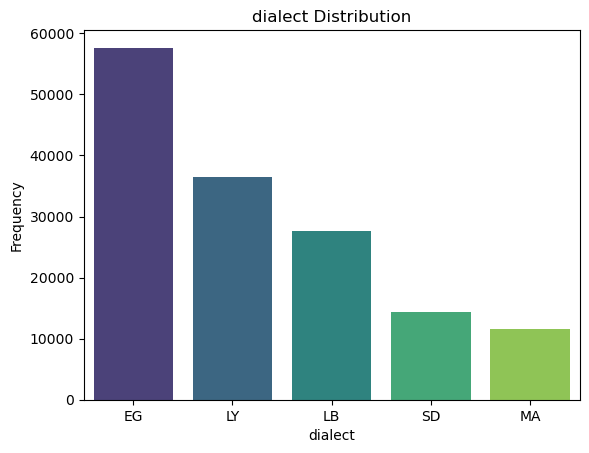


Sample text (index 105876):
 ميوشتي كل عيد حب وانتي ب فرحه يارب

Label EG percentage: 39.02%

Label LY percentage: 24.71%

Label LB percentage: 18.69%

Label SD percentage: 9.77%

Label MA percentage: 7.81%


In [30]:
def EDA(data):
    # Check for NaNs
    nan= data.isnull().any()
    print("NaN check:\n", nan)
    
    # Check for duplicates
    duplicated = data.duplicated() 
    print("\nDuplicated rows:\n", duplicated)
    duplicate_count = data.duplicated().sum()
    print("\nNumber of duplicated rows:", duplicate_count)
    
    # Show a representative sample of data texts
    label_counts = data['dialect'].value_counts()
    print("\ndialect value counts:\n", label_counts)
    
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('dialect Distribution')
    plt.xlabel('dialect')
    plt.ylabel('Frequency')
    plt.show()
    
    # Sample a random text
    sample_index = np.random.randint(0, len(data))
    sample_text = data.iloc[sample_index]['text']
    print("\nSample text (index {}):\n".format(sample_index), sample_text)
    
    # Check dataset balancing
    total_count = df.shape[0]
    for label in label_counts.index:
        label_percentage = (label_counts[label] / total_count) * 100
        print("\nLabel {} percentage: {:.2f}%".format(label, label_percentage))
    
EDA(data)

In [32]:
data.to_csv("D:/iti2/NLP/final project/Data Preprocessing/Preprocessed_data.csv")  